## Intro to convolutional neural networks (CNNs)

In the previous unit we have learned how to define a multi-layered neural network using class definition, but those networks were generic, and not specialized for computer vision tasks. In this unit we will learn about **Convolutional Neural Networks (CNNs)**, which are specifically designed for computer vision.

Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image. 

To extract patterns, we will use the notion of **convolutional filters**. But first, let us load all dependencies and functions that we have defined in the previous units.

In [4]:
from pytorchcv import plot_convolution

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchvision.transforms import ToTensor

In [5]:
data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

batch_size = 128
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

### The convolution operation

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels. Here is an animation with an example:

The first matrix is the image, and the second matrix (3x3) is called the convolutional filter (or kernel): 
1. The filter is placed on top of the image, and the weighted average of the pixels is computed. 
2. The result is placed in the output matrix. 
3. The filter is then moved to the next position, and the process is repeated.
   
![conv1](images/convolution1.gif)

![conv2](images/convolution2.gif)

#### Some particular examples of convolutional filters

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])


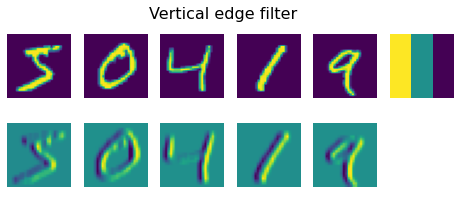

In [6]:
convolution_filter = torch.tensor([[1.,0.,-1.],[1.,0.,-1.],[1.,0.,-1.]])
print(convolution_filter)

plot_convolution(convolution_filter,'Vertical edge filter', data_train)

First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     1 & 0 & -1 \cr
     1 & 0 & -1 \cr
     1 & 0 & -1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])


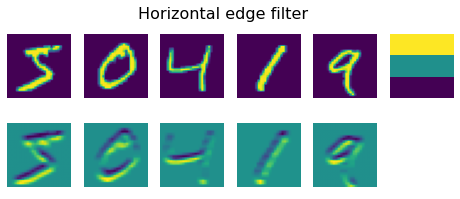

In [7]:
convolution_filter = torch.tensor([[1.,1.,1.],[0.,0.,0.],[-1.,-1.,-1.]])
print(convolution_filter)
plot_convolution(convolution_filter,'Horizontal edge filter', data_train)

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])


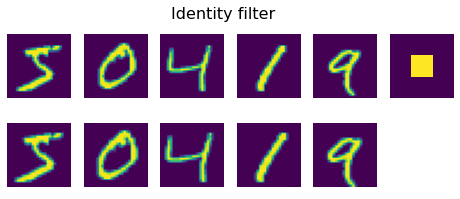

In [8]:
convolution_filter = torch.tensor([[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]])
print(convolution_filter)
plot_convolution(convolution_filter,'Identity filter', data_train)

tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]])


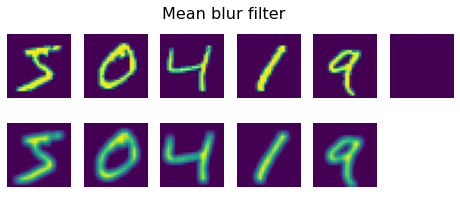

In [9]:
convolution_filter = torch.ones(3,3)/9
print(convolution_filter)
plot_convolution(convolution_filter,'Mean blur filter', data_train)

tensor([[ 0., -1.,  0.],
        [-1.,  5., -1.],
        [ 0., -1.,  0.]])


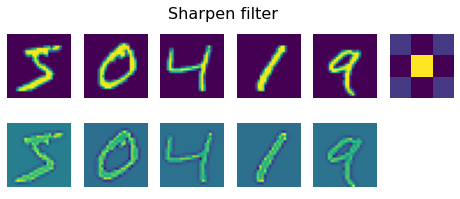

In [10]:
convolution_filter = torch.tensor([[0.,-1.,0.],[-1.,5.,-1.],[0.,-1.,0.]])
print(convolution_filter)
plot_convolution(convolution_filter,'Sharpen filter', data_train)

**In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem.**

To do that, we introduce **convolutional layers** (`nn.Conv2d`):

Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:
* `in_channels` - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1. Color image has 3 channels (RGB).
* `out_channels` - number of convolutional filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used. The choice of filter size is usually chosen by experiment, that is by trying out different filter sizes and comparing resulting accuracy.


In [28]:
import torch.nn as nn

class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.linear = nn.LazyLinear(20)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = self.linear(x)
        return x

net = OneConv()


That is a simple CNN that contains one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels). Here the result of each filter is represented by a different channel in the image (thus the first dimension 9 corresponds to the number of filters).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers. 

In [29]:
net

OneConv(
  (conv): Conv2d(1, 9, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=20, bias=True)
)

In [30]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.CrossEntropyLoss()):
    optimizer = optimizer or torch.optim.SGD(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.CrossEntropyLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.CrossEntropyLoss()):
    optimizer = optimizer or torch.optim.SGD(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [31]:
hist = train(net,train_loader,test_loader,epochs=5,lr=0.05)

Epoch  0, Train acc=0.867, Val acc=0.914, Train loss=0.004, Val loss=0.002
Epoch  1, Train acc=0.938, Val acc=0.946, Train loss=0.002, Val loss=0.001
Epoch  2, Train acc=0.957, Val acc=0.963, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.968, Val acc=0.969, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.973, Val acc=0.973, Train loss=0.001, Val loss=0.001


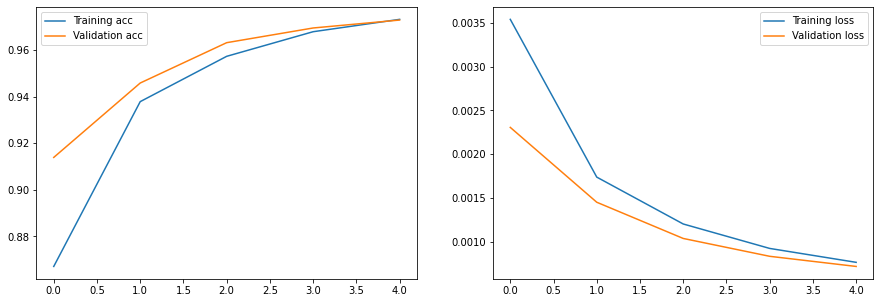

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

You can play with the different hyperparameters, and notice that a single convolutional layer can already achieve quite good accuracy on MNIST dataset (and in less time!)

We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on:

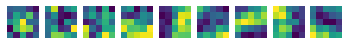

In [33]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

**Question** How are the weights of the convolutional layer before training?
Plot a similar visualization

/Users/victorgallego/miniforge3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


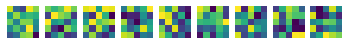

In [34]:
net = OneConv()

fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

#### Conclusions

The Convolutional layer allows us to extract certain image patterns from the image, so that the final classifier is based on top of those features. 

However, we can use the same approach of extracting patterns inside the feature space, by stacking another convolutional layer on top of the first one. We will learn about multi-layer convolutional networks in the next notebook.